In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import os
import random
import math
import pandas as pd
import scipy
import numpy.ma as ma
import itertools
from networkx.algorithms import bipartite
import community
# from infomap import infomap
import os
import rpy2.robjects as robjects
import copy
from scipy import optimize

In [2]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

In [3]:
data_total=ldata('crimen/red_crimenes')
sexos = ldata('crimen/moreno_crime/ent.moreno_crime_crime.person.sex')
nombres = ldata('crimen/moreno_crime/ent.moreno_crime_crime.person.name')
roles = ldata('crimen/moreno_crime/rel.moreno_crime_crime.person.role')

In [4]:
crimenes=[]
personas=[]
red_cr = []
usadosp = []
usadosc = []

for i in data_total:
    if i[1] not in usadosc:
        crimenes.append(i[1]+'cr')
        usadosc.append(i[1])
    if i[0] not in usadosp:
        usadosp.append(i[0])
        personas.append(i[0])
    red_cr.append([i[0],i[1]+'cr']) # En su primer elemento contiene un número que indica a la persona.
                                 # almacenado esto mismo en lista "personas"
                                 # en su segundo elemento un str que contiene al crimen.
                                 # # almacenado esto mismo en lista "crimenes"

## Grafo Bipartito y maxima componente

In [5]:
B = nx.Graph()
B = B.to_undirected()
B.add_nodes_from(personas, bipartite=0)
B.add_nodes_from(crimenes, bipartite=1)
B.add_edges_from(red_cr)

Bmax = max(nx.connected_component_subgraphs(B), key=len)
Bmax = Bmax.to_undirected()

In [6]:
# Asignacion universal de atributos (AUA)
for i in range(2):
    if '1' in bipartite.sets(Bmax)[i]:
        
        for node in bipartite.sets(Bmax)[i]:
            Bmax.node[node]['color']='red'
            Bmax.node[node]['nombre']=nombres[int(node)-1]
            Bmax.node[node]['sexo']=sexos[int(node)-1]
    else:
        for node in bipartite.sets(Bmax)[i]:
            Bmax.node[node]['color']='blue'

for edge in Bmax.edges:
    if [str(edge[0]),str(edge[1])] in red_cr:
        Bmax.edges[edge]['rol']=roles[red_cr.index([str(edge[0]),str(edge[1])])]
    else:
        Bmax.edges[edge]['rol']=roles[red_cr.index([str(edge[1]),str(edge[0])])]

#### (-) Grado de cada set (bipartito)

In [7]:
grados = nx.bipartite.degrees(Bmax, list(Bmax.nodes()), weight=None)
gpers=[]
gcrim = []
for node in Bmax.nodes:
    if node in personas:
        gpers.append(grados[1][node])
    if node in crimenes:
        gcrim.append(grados[1][node])

In [8]:
dic_grados = {}
for element in grados[1]:
    dic_grados[str(element[0])]=str(element[1])

#### Funciones utiles de grado

In [9]:
#GRAFICAR GRADO
def distribucion_de_grado(lista,titulo):
    nro=np.linspace(1,max(lista),max(lista))
    gradpers=np.zeros(len(nro))
    for i in range(len(nro)):
        for g in gpers:
            if g==i+1:
                gradpers[i]=gradpers[i]+1
    plt.plot(nro,gradpers,'*')
    plt.xlabel('Grado')
    plt.ylabel('Numero de nodos')
    plt.title(titulo)
    # plt.savefig('distgrado_'+titulo+'.png')
    plt.show()

In [10]:
#FITEO DE DATOS LOGARITMICOS
# lnro = np.log(np.asarray(nro)!=0)
# lgradpers=np.log(np.asarray(gradpers))


# fitfunc = lambda p, lnro: p[0]*lnro+p[1]
# p0 = [-1, 5]

# errfunc = lambda p, lnro, lgradpers: fitfunc(p, lnro) - lgradpers
# p1, suc = optimize.leastsq(errfunc, p0[:], args=(lnro, lgradpers)) #EL P1 TIENE LOS ELEMENTOS DE MI FITEO. los parametros de mi lineal.
# plt.plot(lnro, lgradpers, "ro", lnro, fitfunc(p1, lnro), "k-", linewidth=3)
# print (p1)

In [11]:
# distribucion_de_grado(gpers,'Bipartita-Pers')
# distribucion_de_grado(gcrim,'Bipartita-Crim')

## Grafo Persona-Persona

In [12]:
PP = max(nx.connected_component_subgraphs(nx.algorithms.bipartite.projection.weighted_projected_graph(B, personas, ratio=False)), key=len)
PP = PP.to_undirected()
# nx.write_gexf(PP,'PP.gexf')
for node in PP.nodes:
    if node in personas:
#         print("hola")
        PP.node[node]['color']='red'
        PP.node[node]['nombre']=nombres[int(node)-1]
#         PP.node[node]['rol']=roles[node-1]
        PP.node[node]['sexo']=sexos[int(node)-1]
    elif node in crimenes:
#         print('FUNCIONA!!!')
        PP.node[node]['color']='blue'

#### Grado (con pesos)

In [13]:
gradosPPw = nx.degree(PP,weight='weight')
gpersPPw=[]
gcrimPPw = []
for node in PP.nodes:
    if node in personas:
        gpersPPw.append(gradosPPw[node])

In [14]:
dic_gradosPPw = {}
for element in gradosPPw:
    dic_gradosPPw[str(element[0])]=str(element[1])

In [135]:
# distribucion_de_grado(gpersPPw,'P-P')

#### Betweenness

In [16]:
centrbet = []
bet = nx.betweenness_centrality(PP,weight='weight')
for node in PP.nodes:
    centrbet.append([node,bet[node]])
centrbet.sort(key=lambda betw: betw[1], reverse=True) #Ordenados de mayor a menor

#### Clustering

In [17]:
clus = nx.clustering(PP, weight='weight')

#### Comunidades

In [18]:
comunidadesPP = community.best_partition(PP)
mod = community.modularity(comunidadesPP,PP)

#### Para Gephi

In [19]:
#Para Gephi quitar todos los atributos y ponerle estos
for node in PP.nodes():
    PP.node[node]['comunidad']=comunidadesPP[node]
    PP.node[node]['betweenness']=bet[node]
            
# nx.write_gexf(PP,'PPposta.gexf')

### Graficar con tamaño de nodos

In [20]:
diccionarios_centralidad = [dic_grados,dic_gradosPPw,bet,clus]
diccionarios_color = [nx.get_node_attributes(Bmax,'bipartite'),comunidadesPP]

In [106]:
#ARREGLAR NO FUNCIONA!!!!!
def graficar_tamaño_color(g,tamaño,dic_tam,color,dic_col,Nfig,Nnod,espesor,wid):
    plt.figure(figsize=(Nfig,Nfig)) #50
    
    if color == 'si':
        colors = list(dic_col.values())
    else:
        colors = 'red'
        
    if tamaño == 'si':
        tamaños = [v * 3 for v in dic_tam.values()]
    else: 
        tamaños = Nnod
        
    if espesor == 'si':
        ancho = [t * wid/max(nx.get_edge_attributes(g,'weight').values()) for t in nx.get_edge_attributes(g,'weight').values()]
    else:
        ancho = 3
    
#     for name,label in comunidadesPP.items():
#         PP.nodes()[name]["color"] = label
    nx.draw_networkx(g, nodelist=list(dic_tam.keys()),
                     node_size=tamaños,
                     cmap=plt.get_cmap('plasma'),
                     node_color=colors,
                     edgelist=list(nx.edges(Bmax).keys()), 
                     width=ancho,
                     edge_color='black',
                     with_labels=False)
#     plt.title('cLUSTERIG')
    # plt.savefig ("Particion_Louvain.png")
# 
    plt.show()

In [111]:
# graficar_tamaño_color(Bmax,'s',diccionarios_centralidad[0],'si',diccionarios_color[1],50,70,'s',10)

### Caracteristicas de red

558 271


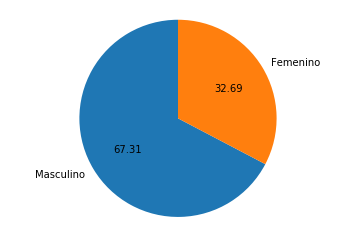

In [23]:
# The slice names of a population distribution pie chart
pieLabels = ['Masculino','Femenino']
 
# Population data
m=0
f=0
for i in sexos:
    if i==['1']:
        m=m+1
    else:
        f=f+1
print(m, f)      
porcentajes = [m,f]

figureObject, axesObject = plt.subplots()
 
# Draw the pie chart
# plt.figure(figsize=(15,15))
axesObject.pie(porcentajes, 
        labels=pieLabels, 
        autopct='%1.2f',
        startangle=90)
 
# Aspect ratio - equal means pie is a circle
axesObject.axis('equal')
# plt.savefig('sexosB.png')
plt.show()

(-1.1010317172415427,
 1.101920484780624,
 -1.1018562982588982,
 1.1000883951551856)

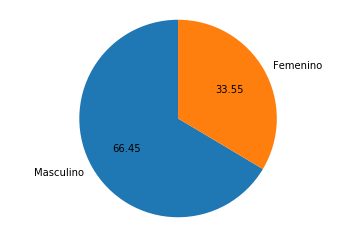

In [24]:
m=0
f=0
for node in PP.nodes:
    if PP.nodes[node]['sexo']==['1']:
        m=m+1
    else:
        f=f+1
porcentajes = [m,f]

figureObject, axesObject = plt.subplots()
 
# Draw the pie chart
# plt.figure(figsize=(15,15))
axesObject.pie(porcentajes, 
        labels=pieLabels, 
        autopct='%1.2f',
        startangle=90)
 
# Aspect ratio - equal means pie is a circle
axesObject.axis('equal')
# plt.savefig('sexosPP.png')
# plt.show()

## Asortatividad

#### Version Juan (listas)

In [25]:
#ASORTATIVIDAD
N_sos = [] #1er elemento, número de crimenes en los que la persona 1 fue sospechoso.
N_test = [] #1er elemento, número de crimenes en los que la persona 1 fue testigo.
N_vict = [] #1er elemento, número de crimenes en los que la persona 1 fue victima.
N_dual = []

NS = 0
NT = 0
NV = 0
ND = 0

for i in range (1,len (data_total)):
    if data_total [i][0] == data_total [i-1][0]:
        if ["Suspect"] == roles [i-1]:
            NS = NS + 1
        elif  ['Witness'] == roles [i-1]:
            NT = NT + 1
        elif ['Victim'] == roles [i-1]:
            NV = NV + 1
        elif ['Victim', 'Suspect'] == roles [i-1]:
            ND = ND + 1

    elif data_total [i][0] != data_total [i-1][0]:

        if ["Suspect"] == roles [i-1]:
            NS = NS + 1
        elif  ['Witness'] == roles [i-1]:
            NT = NT + 1
        elif ['Victim'] == roles [i-1]:
            NV = NV + 1
        elif ['Victim', 'Suspect'] == roles [i-1]:
            ND = ND + 1
        N_sos.append(NS)
        N_test.append(NT)
        N_vict.append(NV)
        N_dual.append(ND)
        NS = 0
        NT = 0
        NV = 0
        ND = 0
        
    try:
        assert (i < (len (data_total)-1))
    except AssertionError:
        if ["Suspect"] == roles [i]:
            NS = NS + 1
        elif  ['Witness'] == roles [i]:
            NT = NT + 1
        elif ['Victim'] == roles [i]:
            NV = NV + 1
        elif ['Victim', 'Suspect'] == roles [i]:
            ND = ND + 1
        N_sos.append(NS)
        N_test.append(NT)
        N_vict.append(NV)
        N_dual.append(ND)

#### Version diccionarios

In [26]:
#Diccionarios con numero de enlaces sospechosos, victimas, testigos y duales
Nsos={}
Nvic={}
Ntest={}
Ndual={}
for node in bipartite.sets(Bmax)[0]:
    v=0
    s=0
    d=0
    t=0
    for edge in Bmax.edges(node):
        if Bmax.edges[edge]['rol']==['Victim']:
            v=v+1
        if Bmax.edges[edge]['rol']==['Suspect']:
            s=s+1
        if Bmax.edges[edge]['rol']==['Witness']:
            t=t+1
        if Bmax.edges[edge]['rol']==['Victim', 'Suspect']:
            d=d+1
    Nsos[node] = s
    Nvic[node] = v
    Ntest[node] = t
    Ndual[node] = d
# print (Nsos)
# print(Nvic)
# print(Ntest)

##### Plotear grado de 'atributo' en funcion del grado medio del mismo atributo en los vecinos

In [27]:
diccionariosN = [Nsos,Nvic,Ntest,Ndual]

def asortatividad(g,dic):
    xnod = []
    xvec = []
    tot = []
    for node in g.nodes:
        xnod.append(dic[node])
        k = 0
        n = 0
        for vecino in g.neighbors(node): #sumo los grados de los vecinos
            k = k + dic[vecino]
            n = n + 1
        xvec.append(k/n)
        tot.append([dic[node],k/n])
    grados = list(set(xnod))
    xprom = []
    for k in grados:
        p = 0
        n = 0
        for i in tot:
            if i[0]==k:
                p = p + i[1]
                n = n + 1
        xprom.append(p/n)    
    
    plt.plot(xnod,xvec,'*')
#     plt.show()
        
    plt.plot(grados,xprom,'r*')
#     plt.yscale('log')
#     plt.xscale('log')
    plt.show
    

##### Funcion que calcula la asortatividad

In [28]:
#Asortatividad
def coef_asort(g, dic):
    
    S1 = 0
    S2 = 0
    Se = 0 
    S3 = 0
    
    for node in g.nodes():

        S1 = S1 + dic[node]
        S2 = S2 + dic[node]**2
        S3 = S3 + dic[node]**3
        
        for vecino in g.neighbors(node):
            Se = Se + dic[node]*dic[vecino]
        
    r = (S1*Se-S2**2)/(S1*S3-S2**2) #ASORTATIVIDAD
    
    return r 

In [29]:
rsos = coef_asort(PP,diccionariosN[0])
rvic = coef_asort(PP,diccionariosN[1])
# print(rsos,rvic)

In [30]:
# asortatividad(PP,diccionariosN[0])
# plt.savefig('Asort-sos.png')

In [31]:
# asortatividad(PP,diccionariosN[1])
# plt.savefig('Asort-vic.png')

## Desarmado de la red

In [32]:
centrgradPP = []
for node in PP.nodes:
    centrgradPP.append([node,PP.degree(weight='weight')[node]])
centrgradPP.sort(key=lambda grado: grado[1], reverse=True)

In [33]:
centrgradBmax=[]
for node in bipartite.sets(Bmax)[0]:
    centrgradBmax.append([node,Bmax.degree(node)])
centrgradBmax.sort(key=lambda clu: clu[1], reverse=True)
# centrgradBmax

In [34]:
centrclus = []
for nodes in list(clus.keys()):
    centrclus.append([nodes,clus[nodes]])
centrclus.sort(key=lambda clu: clu[1], reverse=True)
# centrclus

In [35]:
def impacto_random (g,n):
    for _ in range(n):
        gg = copy.deepcopy(g)
        x = []
        todo=[]
        y = []
        #Tomo la componente gigante de mi grafo. Como criterio se toma el largo (key = len) y tomo el subgrafo con el máximo.
        comp_gig = max (nx.connected_component_subgraphs(gg) , key = len)
        N = int (comp_gig.number_of_nodes())
        i = 0
        while len (comp_gig) > 40: #Modificando el numero podemos determinar hasta cuando va a analizar el largo de la red.
            nodos = [] #Nodos de la componente gigante.
            grados = [] #Grado de ellos.
            for node in  comp_gig.nodes:
                nodos.append (node)
                grados.append (comp_gig.degree(node))
            nodo = random.choice(nodos) #elijo nodo aleatoriamente
            comp_gig.remove_nodes_from([nodo])
            i = i + 1
            x.append (i/float (N))
            comp_gig = max (nx.connected_component_subgraphs(comp_gig) , key = len)
            y.append(len(comp_gig)/float (N)) #IMPORTANTE:El numerador es el largo NUEVO de la componente gigante y#el denominador te da el largo antes de la extracción del nodo central.
   
        todo.append([x,y])
        
    xx=[]
    yy=[]
    xxx=0
    yyy=0
    for i in todo:
        xxx=0
        yyy=0
        for j in range(len(i[0])):
            xxx=i[0][j]/len(todo)+xxx
            yyy=i[1][j]/len(todo)+yyy
        xx.append(xxx)
        yy.append(yyy)
            
            
    return [x,y]

In [36]:
def impacto_parametro (g,param,n):
    gg = copy.deepcopy(g)
    x = []
    todo=[]
    y = []
    #Tomo la componente gigante de mi grafo. Como criterio se toma el largo (key = len) y tomo el subgrafo con el máximo.
    comp_gig = max (nx.connected_component_subgraphs(gg) , key = len)
    N = int (comp_gig.number_of_nodes())
    i = 0
    
    for i in range(n):
        comp_gig.remove_nodes_from([param[i][0]])
        i = i + 1
        x.append (i/float (N))
        comp_gig = max (nx.connected_component_subgraphs(comp_gig) , key = len)
        y.append(len(comp_gig)/float (N)) #IMPORTANTE:El numerador es el largo NUEVO de la componente gigante y#el denominador te da el largo antes de la extracción del nodo central.

    todo.append([x,y])
            
    return [x,y]

In [37]:
grado = impacto_parametro(PP,centrgradPP,200)
# plt.plot(grado[0],grado[1],'k')

In [38]:
bett = impacto_parametro(PP,centrbet,200)
# plt.plot(bett[0],bett[1],'k')

In [39]:
cluss = impacto_parametro(PP,centrclus,500)
# plt.plot(cluss[0],cluss[1],'k')

In [40]:
randomm = impacto_random (PP,10)
# plt.plot(randomm[0],randomm[1],'k')

In [41]:
gradBB = impacto_parametro(PP,centrgradBmax,200)
# plt.plot(gradBB[0],gradBB[1],'k')

In [42]:
# plt.figure(figsize=(10,10))
# plt.plot(grado[0],grado[1],'r',label='Grado en red P-P')
# plt.plot(gradBB[0],gradBB[1],'m',label='Grado en red P-C')
# plt.plot(randomm[0],randomm[1],'k',label='Control Random')
# plt.plot(cluss[0],cluss[1],'b',label='Clustering Local')
# plt.plot(bett[0],bett[1],'g',label='Betweenness')
# plt.xlim(0,0.25)
# plt.xlabel('Fracción de nodos')
# plt.ylabel('Tamaño componente gigante')
# plt.legend()
# # plt.savefig('Desarmado.png')

# plt.show()

# Objetivo 1

### Overlap que tuvieron los rankings

In [43]:
rankings=[centrbet,centrgradBmax,centrgradPP,centrclus]
lista_rank=[]
for i in range(len(rankings)):
    lista_rank.append([])
    for j in range(20):
        lista_rank[i].append(PP.nodes[rankings[i][j][0]]['nombre'][0])
# print(lista_rank)

overlap=[]
for i in range(len(lista_rank)-1):
    overlap.append([])
    for j in range(i+1,len(rankings)):
        overlap[i].append([])
        for elem in lista_rank[i]:
            if elem in lista_rank[j]:
                overlap[i][j-i-1].append(elem)
print(overlap)
for i in range(3):
    print(rankings[i][0:20])

[[['WillisJenny', 'AbramsChad', 'BendixJerryLee', 'SteinerCatherine', 'HemphillBud', 'KatzLuella', 'McCannEddie'], ['WillisJenny', 'AbramsChad', 'BendixJerryLee', 'SteinerCatherine', 'HemphillBud', 'KatzLuella', 'AlexanderNolan'], []], [['WillisJenny', 'AbramsChad', 'KatzLuella', 'BendixJerryLee', 'SteinerCatherine', 'SmithMichaelThomas', 'HemphillBud', 'JeffersonArnold', 'MitchellGrant', 'MarcusBradley'], []], [[]]]
[['815', 0.43733736612485763], ['690', 0.31467435293946344], ['2', 0.23101207772605534], ['56', 0.1890596191112173], ['715', 0.18728411463346759], ['439', 0.17090593101809629], ['333', 0.15447606680690176], ['356', 0.14477283616740497], ['425', 0.14000558380498643], ['17', 0.12900441578081576], ['424', 0.12398431969512357], ['62', 0.1186071317566613], ['812', 0.11450224229188283], ['567', 0.11387732847941694], ['46', 0.11241396244205827], ['10', 0.11119969187021592], ['400', 0.10249411757550943], ['514', 0.10032034946070532], ['449', 0.09888002782714451], ['719', 0.0966014

In [44]:
def rol_mayor(rank):
    rol = []
    for item in rank:
        prop = [Nsos[str(item[0])],Nvic[str(item[0])],Ntest[str(item[0])],Ndual[str(item[0])]]
        roll = ['s','v','t','d']
        if prop[0]/sum(prop)>=0.5:
            rol.append([str(item[0]),prop[0]/sum(prop),'s'])
        else:
            rol.append([str(item[0]),max(prop)/sum(prop),roll[prop.index(max(prop))]])
    return rol

In [69]:
A=[]
for i in range(1,10):
    A.append([PP.degree(str(i),weight='weight'),Nsos[str(i)]+Ntest[str(i)]+Ndual[str(i)]+Nvic[str(i)]])
A

[[4, 4], [55, 22], [1, 1], [7, 1], [7, 1], [7, 1], [5, 1], [3, 1], [3, 1]]

In [88]:
def distribucion_aleatoria(g,rank,n):
    rol_aleatorio = copy.deepcopy(roles)
#     print(rol_aleatorio)
    sospechosos = []
    victimas = []
    testigos = []
    for item in rank[0:20]:
        sospechosos.append([item[0],100*Nsos[str(item[0])]/(Nsos[str(item[0])]+Ntest[str(item[0])]+Ndual[str(item[0])]+Nvic[str(item[0])])])
        victimas.append([item[0],100*Nvic[str(item[0])]/(Nsos[str(item[0])]+Ntest[str(item[0])]+Ndual[str(item[0])]+Nvic[str(item[0])])])
        testigos.append([item[0],100*Ntest[str(item[0])]/(Nsos[str(item[0])]+Ntest[str(item[0])]+Ndual[str(item[0])]+Nvic[str(item[0])])])
    print(len(sospechosos))
    for _ in range(n):
        random.shuffle(rol_aleatorio)
        contador = 0
        j = 0
        for item in rank[0:20]:
            k = Nsos[str(item[0])]+Ntest[str(item[0])]+Ndual[str(item[0])]+Nvic[str(item[0])]
#             print(k)
            NS = 0
            NT = 0
            NV = 0
            ND = 0
            for i in range(k):
#                 print(i+contador)
                if rol_aleatorio[i+contador] == ["Suspect"]:
                    NS = NS + 1
                if rol_aleatorio[i+contador] == ['Witness']:
                    NT = NT + 1
                if rol_aleatorio[i+contador] == ['Victim']:
                    NV = NV + 1
                if rol_aleatorio[i+contador] == ['Victim', 'Suspect']:
                    NS = NS + 1
            sospechosos[j].append(100*NS/k)
            victimas[j].append(100*NV/k)
            testigos[j].append(100*NT/k)
            contador = contador + k
            j = j + 1        
            
    #Levanto el histograma (sospechosos)
    plt.figure(figsize=(8,8))
    for i in range(len(sospechosos)):
        plt.hist (sospechosos[i][2:n])
        plt.title(str(Bmax.nodes[sospechosos[i][0]]['nombre'][0])+' - '+str(sospechosos[i][0]))
        plt.xlabel('Porcentaje de veces que fue sospechoso (%)')
        plt.axvline(x=sospechosos[i][1], linewidth=1, color='r',label=sospechosos[i][1])
        print(sospechosos[i][1])
    #     plt.ylabel ("Distribución")
#         plt.title (label[u])
        plt.legend()
        plt.show()

20
92.0


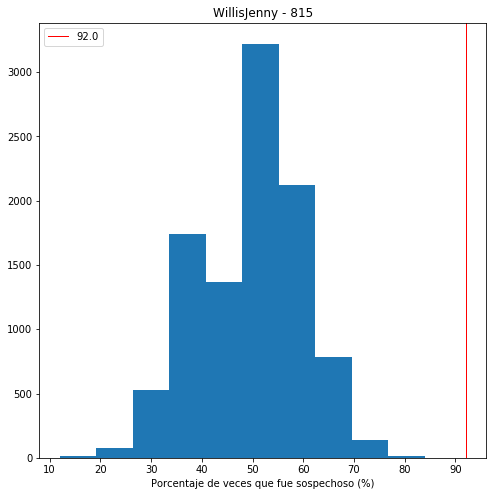

85.71428571428571


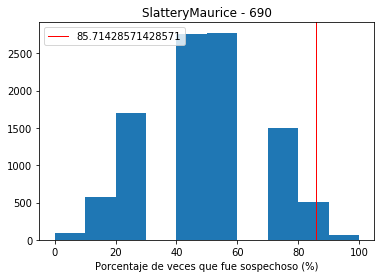

77.27272727272727


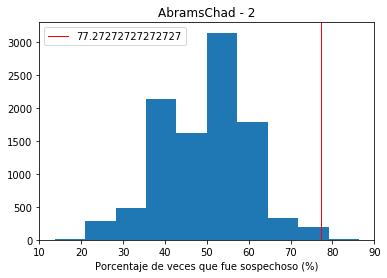

21.428571428571427


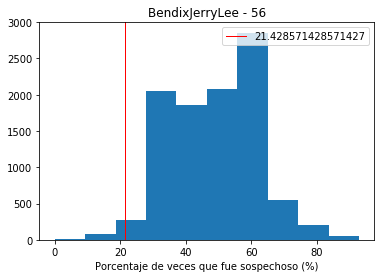

91.66666666666667


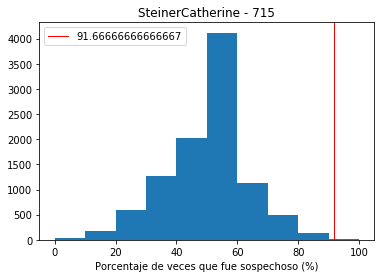

33.333333333333336


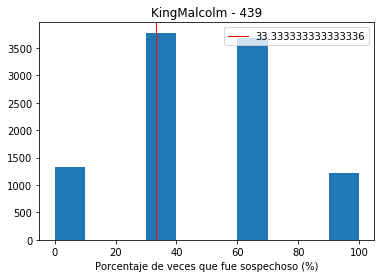

25.0


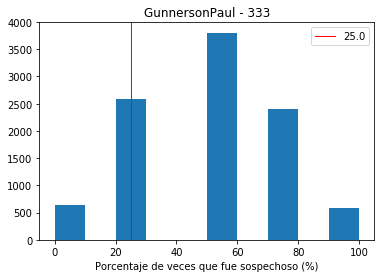

81.81818181818181


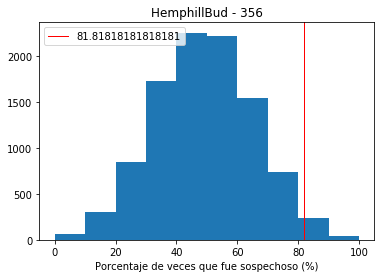

83.33333333333333


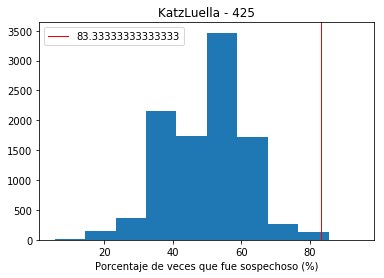

100.0


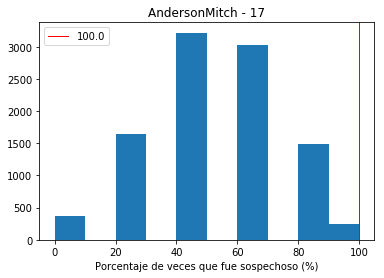

50.0


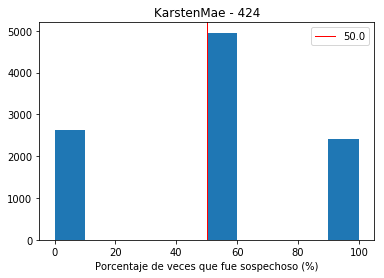

66.66666666666667


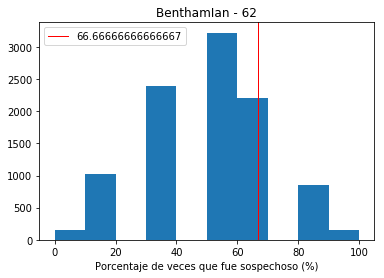

50.0


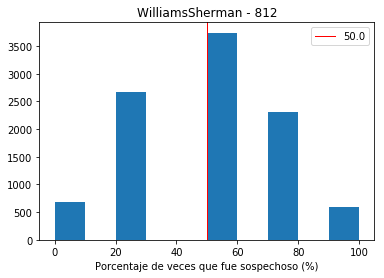

66.66666666666667


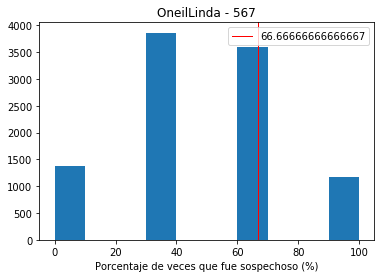

0.0


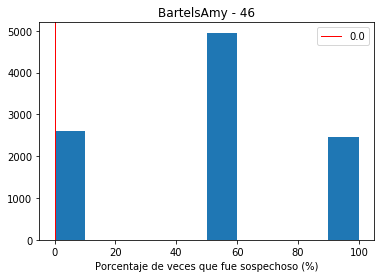

50.0


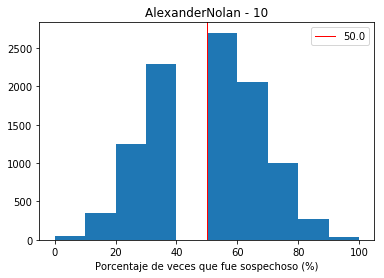

0.0


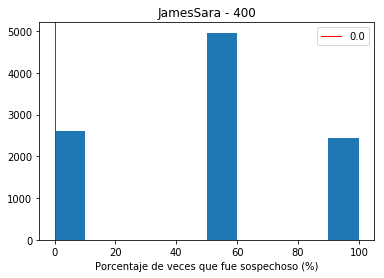

27.272727272727273


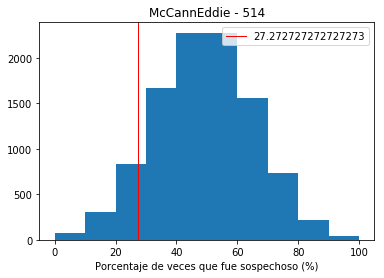

50.0


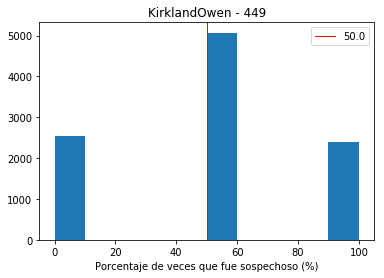

66.66666666666667


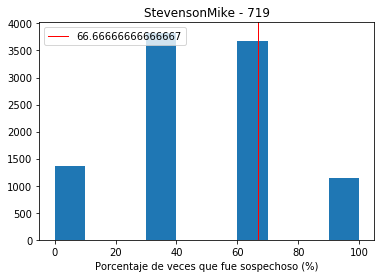

In [89]:
distribucion_aleatoria(PP,rankings[0],10000)

In [62]:
listab = rol_mayor(rankings[0][0:20])
print(listab)
listag = rol_mayor(rankings[1][0:20])
print(listag)
listabgPP = rol_mayor(rankings[2][0:20])
print(listabgPP)

[['815', 0.92, 's'], ['690', 0.8571428571428571, 's'], ['2', 0.7727272727272727, 's'], ['56', 0.5, 'v'], ['715', 0.9166666666666666, 's'], ['439', 0.3333333333333333, 's'], ['333', 0.5, 't'], ['356', 0.8181818181818182, 's'], ['425', 0.8333333333333334, 's'], ['17', 1.0, 's'], ['424', 0.5, 's'], ['62', 0.6666666666666666, 's'], ['812', 0.5, 's'], ['567', 0.6666666666666666, 's'], ['46', 1.0, 't'], ['10', 0.5, 's'], ['400', 0.5, 'v'], ['514', 0.6363636363636364, 'v'], ['449', 0.5, 's'], ['719', 0.6666666666666666, 's']]
[['815', 0.92, 's'], ['2', 0.7727272727272727, 's'], ['425', 0.8333333333333334, 's'], ['220', 0.8235294117647058, 's'], ['56', 0.5, 'v'], ['715', 0.9166666666666666, 's'], ['695', 0.8181818181818182, 's'], ['514', 0.6363636363636364, 'v'], ['356', 0.8181818181818182, 's'], ['404', 0.6, 'v'], ['531', 0.5, 's'], ['696', 0.7777777777777778, 's'], ['592', 0.7777777777777778, 's'], ['115', 1.0, 's'], ['659', 0.8888888888888888, 'v'], ['474', 0.7777777777777778, 's'], ['497',

In [49]:
rol_mayoritario = []
#Primer estimador permite ver aquellas personas que tuvieron un porcentaje de algún rol mayor al 50%
#Segundo estimador permite ver aquellas personas que no habiendo superado el 50% en ningún rol sin embargo estan por encima
#de otro valor. Alterando este segundo estimador podes observar el porcentaje de los otros roles.
# Para este ultimo comentario probar estimador2 = 0.49 y ver la persona 89, luego probar estimador2 = 0.30 y ver la misma
#persona.
# estimador1 = 0.70
# estimador2 = 0.30
estimador1 = 0.99
estimador2 = 0.01
for l in range (len(N_sos)):
    crim_tot = N_sos[l] + N_test[l] + N_vict [l] + N_dual[l]
    prop = [[N_sos[l]/crim_tot,'s'],[N_test[l]/crim_tot,'t'],[N_vict[l]/crim_tot,'v'],[N_dual[l]/crim_tot,'d']]
    if any (i[0] > estimador1 for i in prop) is True:
        for k in prop:
            if k[0] > estimador1:
                rol_mayoritario.append([str(l+1),[k[0],k[1]]])
    else:
        pers_rol = []
        for r in prop:
            if r[0] > estimador2:
                pers_rol.append (r)
        if len(pers_rol) == 1:
            rol_mayoritario.append([str(l+1),pers_rol[0]])
        else:
            rol_mayoritario.append ([str(l+1),pers_rol])
rol_mayoritario

[['1', [[0.5, 's'], [0.5, 'v']]],
 ['2',
  [[0.7727272727272727, 's'],
   [0.045454545454545456, 't'],
   [0.18181818181818182, 'v']]],
 ['3', [1.0, 's']],
 ['4', [1.0, 's']],
 ['5', [1.0, 'v']],
 ['6', [1.0, 'v']],
 ['7', [1.0, 's']],
 ['8', [1.0, 's']],
 ['9', [1.0, 'v']],
 ['10', [[0.5, 's'], [0.125, 't'], [0.25, 'v'], [0.125, 'd']]],
 ['11', [1.0, 'v']],
 ['12', [1.0, 'v']],
 ['13', [1.0, 'v']],
 ['14', [1.0, 'v']],
 ['15', [1.0, 's']],
 ['16', [1.0, 't']],
 ['17', [1.0, 's']],
 ['18', [1.0, 's']],
 ['19', [1.0, 's']],
 ['20', [1.0, 's']],
 ['21', [1.0, 'v']],
 ['22', [1.0, 'd']],
 ['23', [1.0, 's']],
 ['24', [1.0, 's']],
 ['25', [1.0, 's']],
 ['26', [1.0, 's']],
 ['27', [1.0, 'v']],
 ['28', [1.0, 'v']],
 ['29', [1.0, 's']],
 ['30', [1.0, 'v']],
 ['31', [1.0, 'v']],
 ['32', [1.0, 'v']],
 ['33', [1.0, 'v']],
 ['34', [1.0, 's']],
 ['35', [1.0, 's']],
 ['36', [1.0, 's']],
 ['37', [[0.75, 's'], [0.125, 't'], [0.125, 'v']]],
 ['38', [1.0, 's']],
 ['39', [1.0, 's']],
 ['40', [[0.5, 't'],

In [50]:
PP.degree('41',weight='weight')

3

In [51]:
bet_rol = []
for i in range (20):
    persona = int (centrbet[i][0])
    bet_rol.append(rol_mayoritario[persona-1]) 

### Para red aleatoria

In [52]:
Nbet_rol = []

rol_aleatorio = copy.deepcopy(roles)

for i in range (10):
    random.shuffle(rol_aleatorio)
    N_sos = [] 
    N_test = []
    N_vict = []
    N_dual = []

    NS = 0
    NT = 0
    NV = 0
    ND = 0

    for i in range (1,len (data_total)):
        if data_total [i][0] == data_total [i-1][0]:
            if ["Suspect"] == rol_aleatorio [i-1]:
                NS = NS + 1
            elif  ['Witness'] == rol_aleatorio [i-1]:
                NT = NT + 1
            elif ['Victim'] == rol_aleatorio [i-1]:
                NV = NV + 1
            elif ['Victim', 'Suspect'] == rol_aleatorio [i-1]:
                ND = ND + 1

        elif data_total [i][0] != data_total [i-1][0]:

            if ["Suspect"] == rol_aleatorio [i-1]:
                NS = NS + 1
            elif  ['Witness'] == rol_aleatorio [i-1]:
                NT = NT + 1
            elif ['Victim'] == rol_aleatorio [i-1]:
                NV = NV + 1
            elif ['Victim', 'Suspect'] == rol_aleatorio [i-1]:
                ND = ND + 1
            N_sos.append(NS)
            N_test.append(NT)
            N_vict.append(NV)
            N_dual.append(ND)
            NS = 0
            NT = 0
            NV = 0
            ND = 0

        try:
            assert (i < (len (data_total)-1))
        except AssertionError:
            if ["Suspect"] == rol_aleatorio [i]:
                NS = NS + 1
            elif  ['Witness'] == rol_aleatorio [i]:
                NT = NT + 1
            elif ['Victim'] == rol_aleatorio [i]:
                NV = NV + 1
            elif ['Victim', 'Suspect'] == rol_aleatorio [i]:
                ND = ND + 1
            N_sos.append(NS)
            N_test.append(NT)
            N_vict.append(NV)
            N_dual.append(ND)
            
            
    rol_mayoritario = []
    estimador1 = 0.99
    estimador2 = 0.01
    for l in range (len(N_sos)):
        crim_tot = N_sos[l] + N_test[l] + N_vict [l] + N_dual[l]
        prop = [[N_sos[l]/crim_tot,'s'],[N_test[l]/crim_tot,'t'],[N_vict[l]/crim_tot,'v'],[N_dual[l]/crim_tot,'d']]
        if any (i[0] > estimador1 for i in prop) is True:
            for k in prop:
                if k[0] > estimador1:
                    rol_mayoritario.append([str(l+1),[k[0],k[1]]])
        else:
            pers_rol = []
            for r in prop:
                if r[0] > estimador2:
                    pers_rol.append (r)
            if len(pers_rol) == 1:
                rol_mayoritario.append([str(l+1),pers_rol[0]])
            else:
                rol_mayoritario.append ([str(l+1),pers_rol])
    
    
    bet_rol = []
    for i in range (20):
        persona = int (centrbet[i][0])
        bet_rol.append(rol_mayoritario[persona-1])          
    
    Nbet_rol.append (bet_rol)

# Objetivo 3:
## Encontrar los enlaces mas pesados, ver si corresponden a sospechosos y ver como afectan a la red

In [53]:
ejes = []
pesos = []
for edge in PP.edges():
    ejes.append([edge,PP.edges[edge]['weight']])
    pesos.append(PP.edges[edge]['weight'])
ejes.sort(key=lambda p: p[1], reverse=True)
pesos.sort(reverse=True)

peso_persona_sos = []
peso_persona_sos.append(['Peso,Pers, S,V,D,  Sex,     Pers,   S, V, D,   Sex'])
for i in ejes:
    peso_persona_sos.append([i[1],i[0][0],[Nsos[i[0][0]],Nvic[i[0][0]],Ndual[i[0][0]],[Bmax.nodes[i[0][0]]['sexo']]],i[0][1],[Nsos[i[0][1]],Nvic[i[0][1]],Ndual[i[0][1]],[Bmax.nodes[i[0][1]]['sexo']]]])
peso_persona_sos

[['Peso,Pers, S,V,D,  Sex,     Pers,   S, V, D,   Sex'],
 [5, '79', [0, 6, 0, [['0']]], '767', [6, 0, 0, [['1']]]],
 [5, '128', [0, 5, 0, [['0']]], '531', [5, 3, 1, [['1']]]],
 [5, '425', [15, 2, 0, [['0']]], '715', [11, 0, 0, [['0']]]],
 [4, '2', [17, 4, 0, [['1']]], '67', [0, 3, 0, [['0']]]],
 [4, '17', [5, 0, 0, [['1']]], '514', [3, 7, 0, [['1']]]],
 [4, '87', [4, 0, 0, [['1']]], '659', [0, 8, 0, [['1']]]],
 [4, '413', [6, 0, 0, [['1']]], '425', [15, 2, 0, [['0']]]],
 [4, '533', [4, 1, 1, [['1']]], '572', [2, 4, 0, [['1']]]],
 [3, '37', [6, 1, 0, [['1']]], '797', [5, 2, 0, [['1']]]],
 [3, '54', [2, 1, 0, [['1']]], '425', [15, 2, 0, [['0']]]],
 [3, '56', [3, 7, 2, [['1']]], '303', [0, 2, 0, [['0']]]],
 [3, '333', [1, 1, 0, [['1']]], '592', [7, 2, 0, [['0']]]],
 [3, '344', [1, 4, 0, [['1']]], '696', [7, 2, 0, [['0']]]],
 [3, '396', [4, 0, 0, [['0']]], '531', [5, 3, 1, [['1']]]],
 [3, '413', [6, 0, 0, [['1']]], '695', [9, 1, 0, [['1']]]],
 [3, '425', [15, 2, 0, [['0']]], '695', [9, 1, 

In [54]:
persona_sos_vic=[]
for element in peso_persona_sos:
    if len(element)>1:
        if element[0]>2:
            v1=0
            v2=0
            s1=0
            s2=0
            for crimen in nx.common_neighbors(Bmax,element[1],element[3]):
#                 print((crimen,element[1]))
                if Bmax.edges[(crimen,element[1])]['rol']==['Suspect']:
                    s1=s1+1
                if Bmax.edges[(crimen,element[1])]['rol']==['Victim','Suspect']:
                    s1=s1+1
                if Bmax.edges[(crimen,element[3])]['rol']==['Suspect']:
                    s2=s2+1
                if Bmax.edges[(crimen,element[1])]['rol']==['Victim','Suspect']:
                    s2=s2+1
                if Bmax.edges[(crimen,element[1])]['rol']==['Victim']:
                    v1=v1+1
                if Bmax.edges[(crimen,element[3])]['rol']==['Victim']:
                    v2=v2+1
            persona_sos_vic.append([element[0],[element[1],s1,v1,comunidadesPP[element[1]]],[element[3],s2,v2,comunidadesPP[element[3]]]])
persona_sos_vic

[[5, ['79', 0, 5, 17], ['767', 5, 0, 17]],
 [5, ['128', 0, 4, 3], ['531', 4, 0, 3]],
 [5, ['425', 4, 0, 3], ['715', 4, 0, 3]],
 [4, ['2', 4, 0, 1], ['67', 0, 3, 1]],
 [4, ['17', 4, 0, 0], ['514', 0, 3, 0]],
 [4, ['87', 4, 0, 15], ['659', 0, 4, 15]],
 [4, ['413', 4, 0, 3], ['425', 4, 0, 3]],
 [4, ['533', 3, 1, 3], ['572', 1, 2, 3]],
 [3, ['37', 2, 0, 7], ['797', 2, 1, 7]],
 [3, ['54', 2, 0, 3], ['425', 3, 0, 3]],
 [3, ['56', 0, 2, 8], ['303', 0, 2, 8]],
 [3, ['333', 0, 1, 13], ['592', 1, 2, 13]],
 [3, ['344', 0, 3, 22], ['696', 3, 0, 22]],
 [3, ['396', 2, 0, 3], ['531', 0, 2, 3]],
 [3, ['413', 3, 0, 3], ['695', 3, 0, 3]],
 [3, ['425', 2, 0, 3], ['695', 2, 0, 3]],
 [3, ['663', 0, 2, 10], ['815', 3, 0, 10]],
 [3, ['695', 2, 0, 3], ['715', 2, 0, 3]]]

In [55]:
for i in persona_sos_vic:
    if i[1][1]>i[0]/2 and i[2][1]>i[0]/2:
        i.append('Grupo Sospechoso')
    if (i[1][1]>i[0]/2 and i[2][2]>i[0]/2) or (i[1][2]>i[0]/2 and i[2][1]>i[0]/2):
        i.append('Persona atacada')
    if i[1][2]>i[0]/2 and i[2][2]>i[0]/2:
        i.append('Grupo de Victimas')
persona_sos_vic

[[5, ['79', 0, 5, 17], ['767', 5, 0, 17], 'Persona atacada'],
 [5, ['128', 0, 4, 3], ['531', 4, 0, 3], 'Persona atacada'],
 [5, ['425', 4, 0, 3], ['715', 4, 0, 3], 'Grupo Sospechoso'],
 [4, ['2', 4, 0, 1], ['67', 0, 3, 1], 'Persona atacada'],
 [4, ['17', 4, 0, 0], ['514', 0, 3, 0], 'Persona atacada'],
 [4, ['87', 4, 0, 15], ['659', 0, 4, 15], 'Persona atacada'],
 [4, ['413', 4, 0, 3], ['425', 4, 0, 3], 'Grupo Sospechoso'],
 [4, ['533', 3, 1, 3], ['572', 1, 2, 3]],
 [3, ['37', 2, 0, 7], ['797', 2, 1, 7], 'Grupo Sospechoso'],
 [3, ['54', 2, 0, 3], ['425', 3, 0, 3], 'Grupo Sospechoso'],
 [3, ['56', 0, 2, 8], ['303', 0, 2, 8], 'Grupo de Victimas'],
 [3, ['333', 0, 1, 13], ['592', 1, 2, 13]],
 [3, ['344', 0, 3, 22], ['696', 3, 0, 22], 'Persona atacada'],
 [3, ['396', 2, 0, 3], ['531', 0, 2, 3], 'Persona atacada'],
 [3, ['413', 3, 0, 3], ['695', 3, 0, 3], 'Grupo Sospechoso'],
 [3, ['425', 2, 0, 3], ['695', 2, 0, 3], 'Grupo Sospechoso'],
 [3, ['663', 0, 2, 10], ['815', 3, 0, 10], 'Persona ata

In [56]:
for edge in PP.edges():
    PP.edges[edge]['Color']='Black'
    
for element in persona_sos_vic:
    if len(element)>3:
        if element[3]=='Persona atacada':
            PP.edges[(element[1][0],element[2][0])]['Color']='Blue'
        if element[3]=='Grupo Sospechoso':
            PP.edges[(element[1][0],element[2][0])]['Color']='Red'
        if element[3]=='Grupo de Victimas':
            PP.edges[(element[1][0],element[2][0])]['Color']='Green'
            

In [57]:
listaejes=[]
colorejes=[]
for edge in PP.edges():
    if PP.edges[edge]['Color'] != 'Black':
        listaejes.append(edge)
        colorejes.append(PP.edges[edge]['Color'])
listaejes
colorejes

['Blue',
 'Blue',
 'Red',
 'Red',
 'Green',
 'Blue',
 'Blue',
 'Blue',
 'Blue',
 'Blue',
 'Red',
 'Red',
 'Red',
 'Red',
 'Blue',
 'Red']

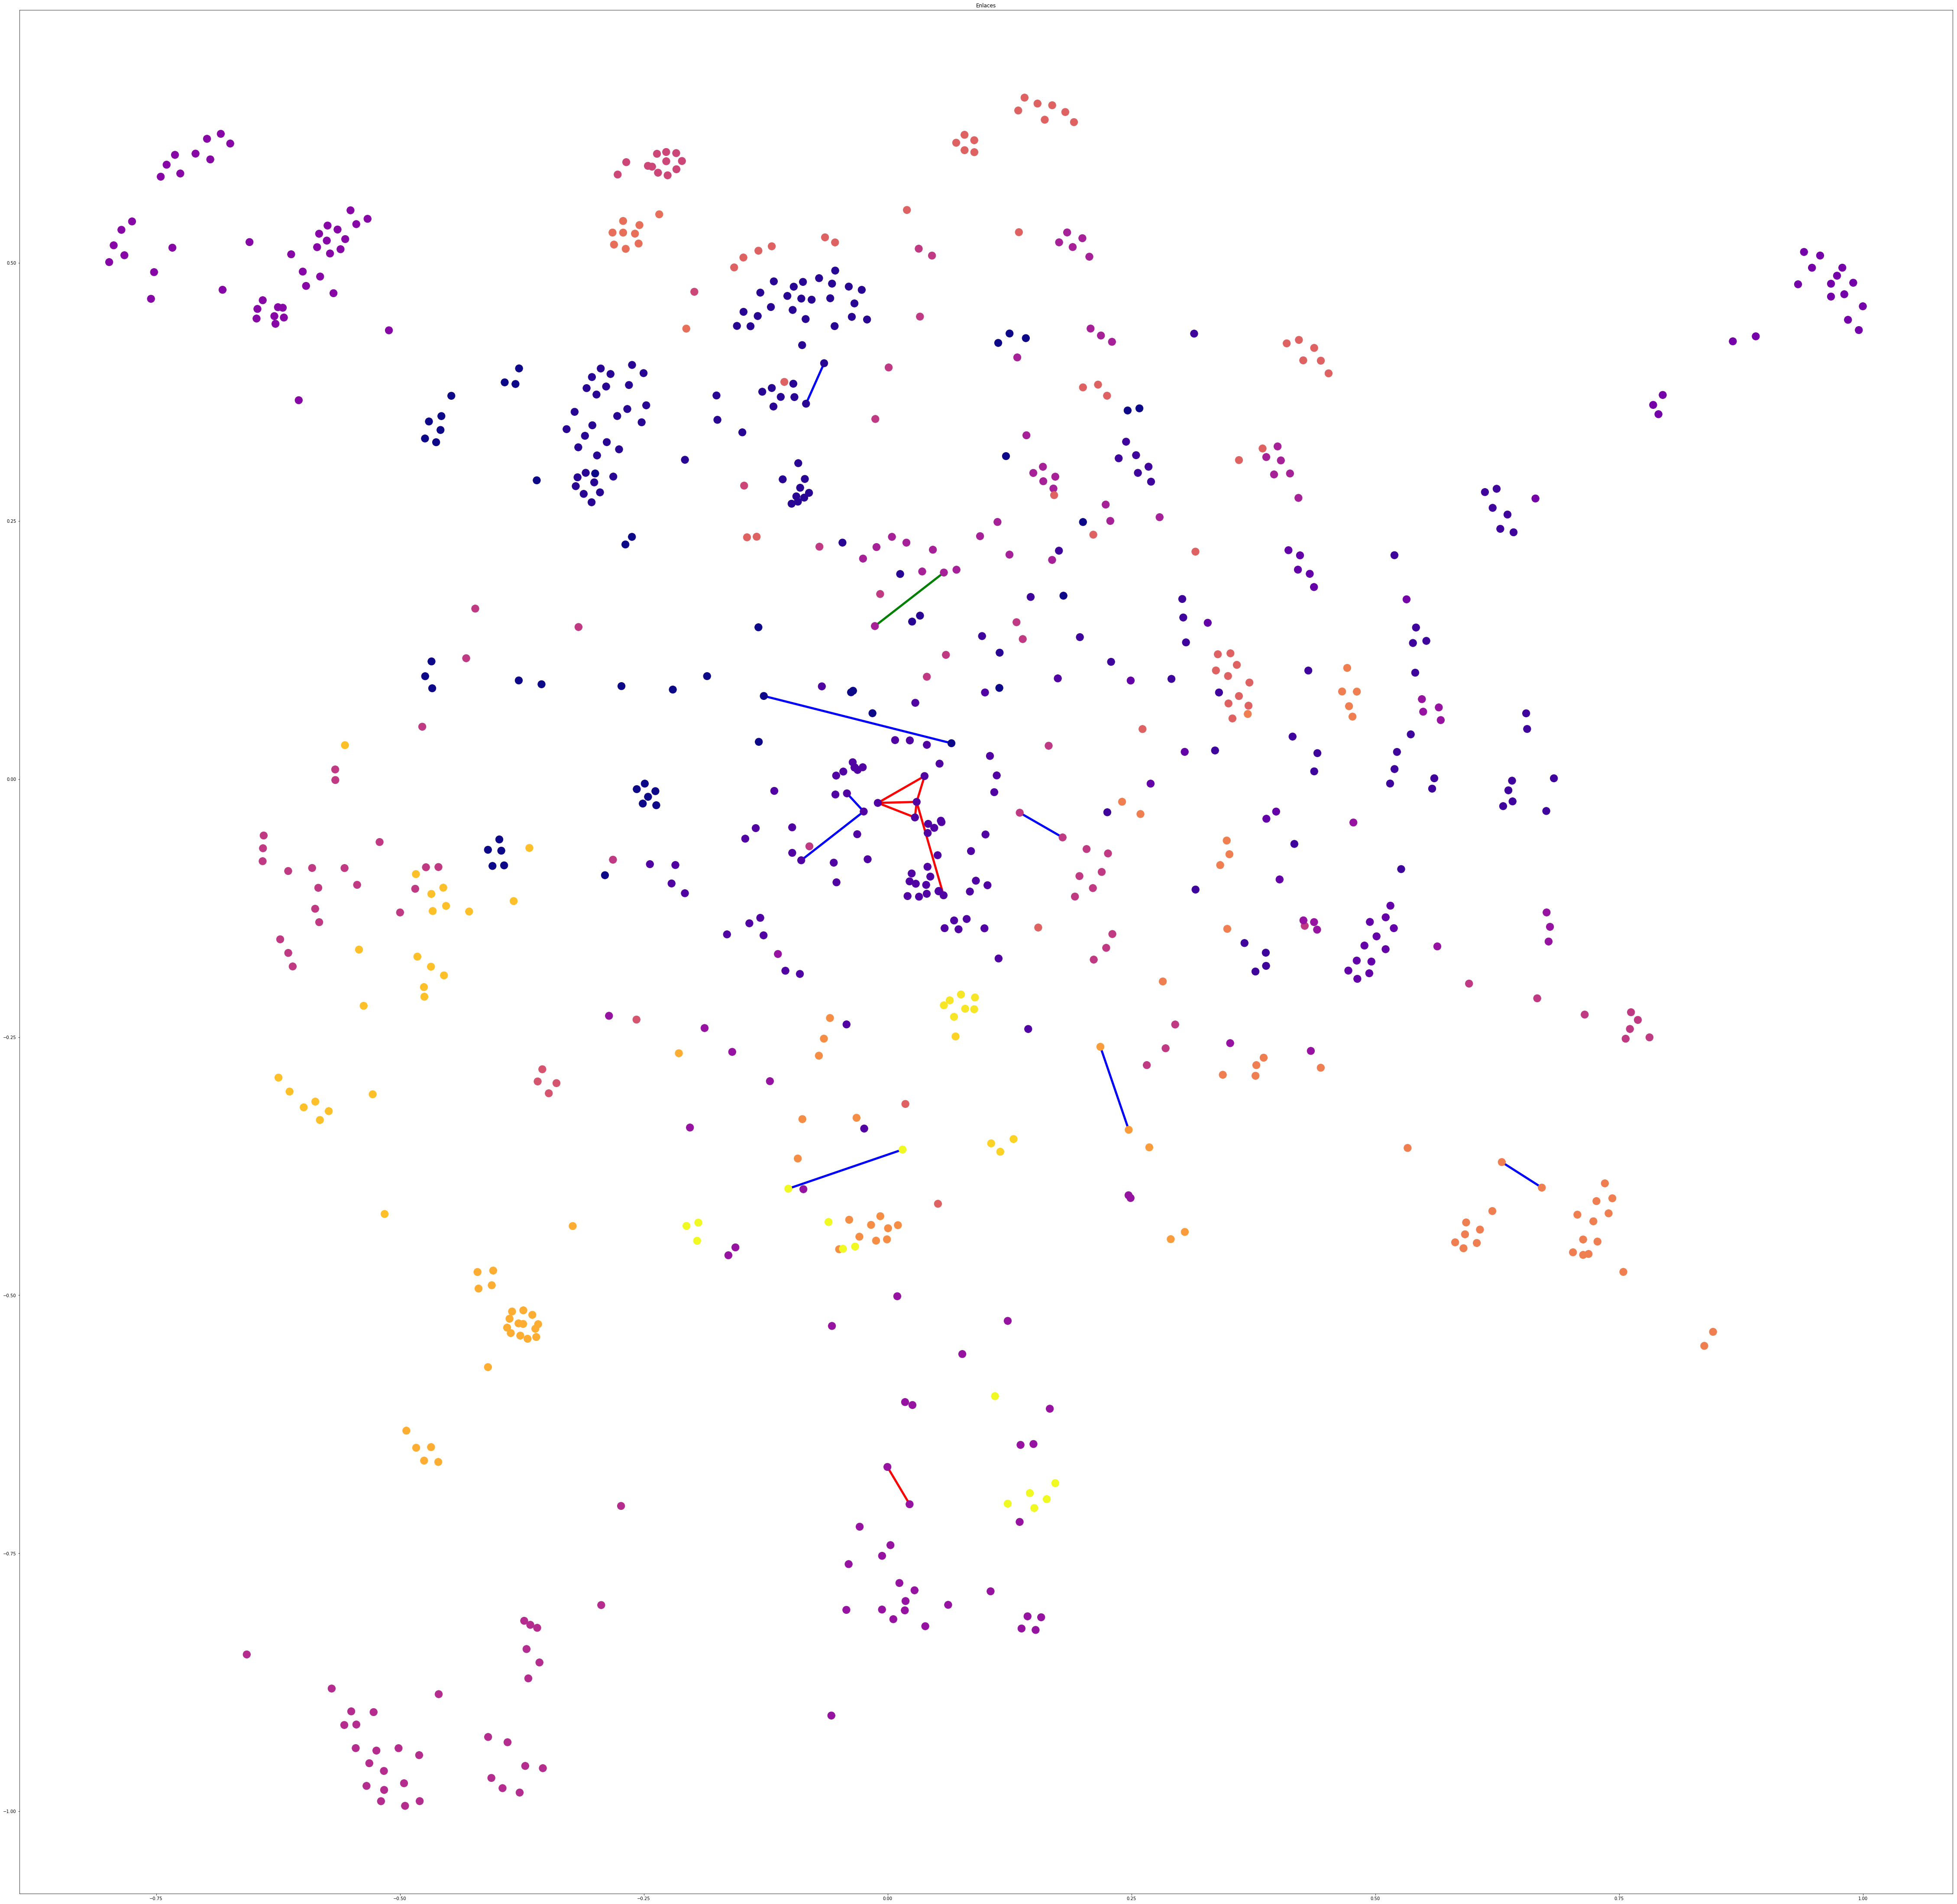

In [58]:
plt.figure(figsize=(80,80))
for name,label in comunidadesPP.items():
    PP.nodes()[name]["color"] = label

nx.draw_networkx(PP, nodelist=list(bet.keys()), 
#                  node_size=[v * 30000 for v in bet.values()],
                 cmap=plt.get_cmap('plasma'),
                 node_color=list(nx.get_node_attributes(PP,'color').values()),
#                  edgelist=list(nx.get_edge_attributes(PP,'Color').keys()),
                 edgelist=listaejes,
#                  edge_color=list(nx.get_edge_attributes(PP,'Color').values()),
                 edge_color=colorejes,
#                  width=[t * 10/max(nx.get_edge_attributes(PP,'weight').values()) for t in nx.get_edge_attributes(PP,'weight').values()],
#                  edge_color=['blue' if list(nx.get_edge_attributes(PP,'weight').values())>=5],
                 width=5,
                 with_labels=False)
plt.title('Enlaces')
# plt.savefig ("Particion_Louvain.png")
plt.show()

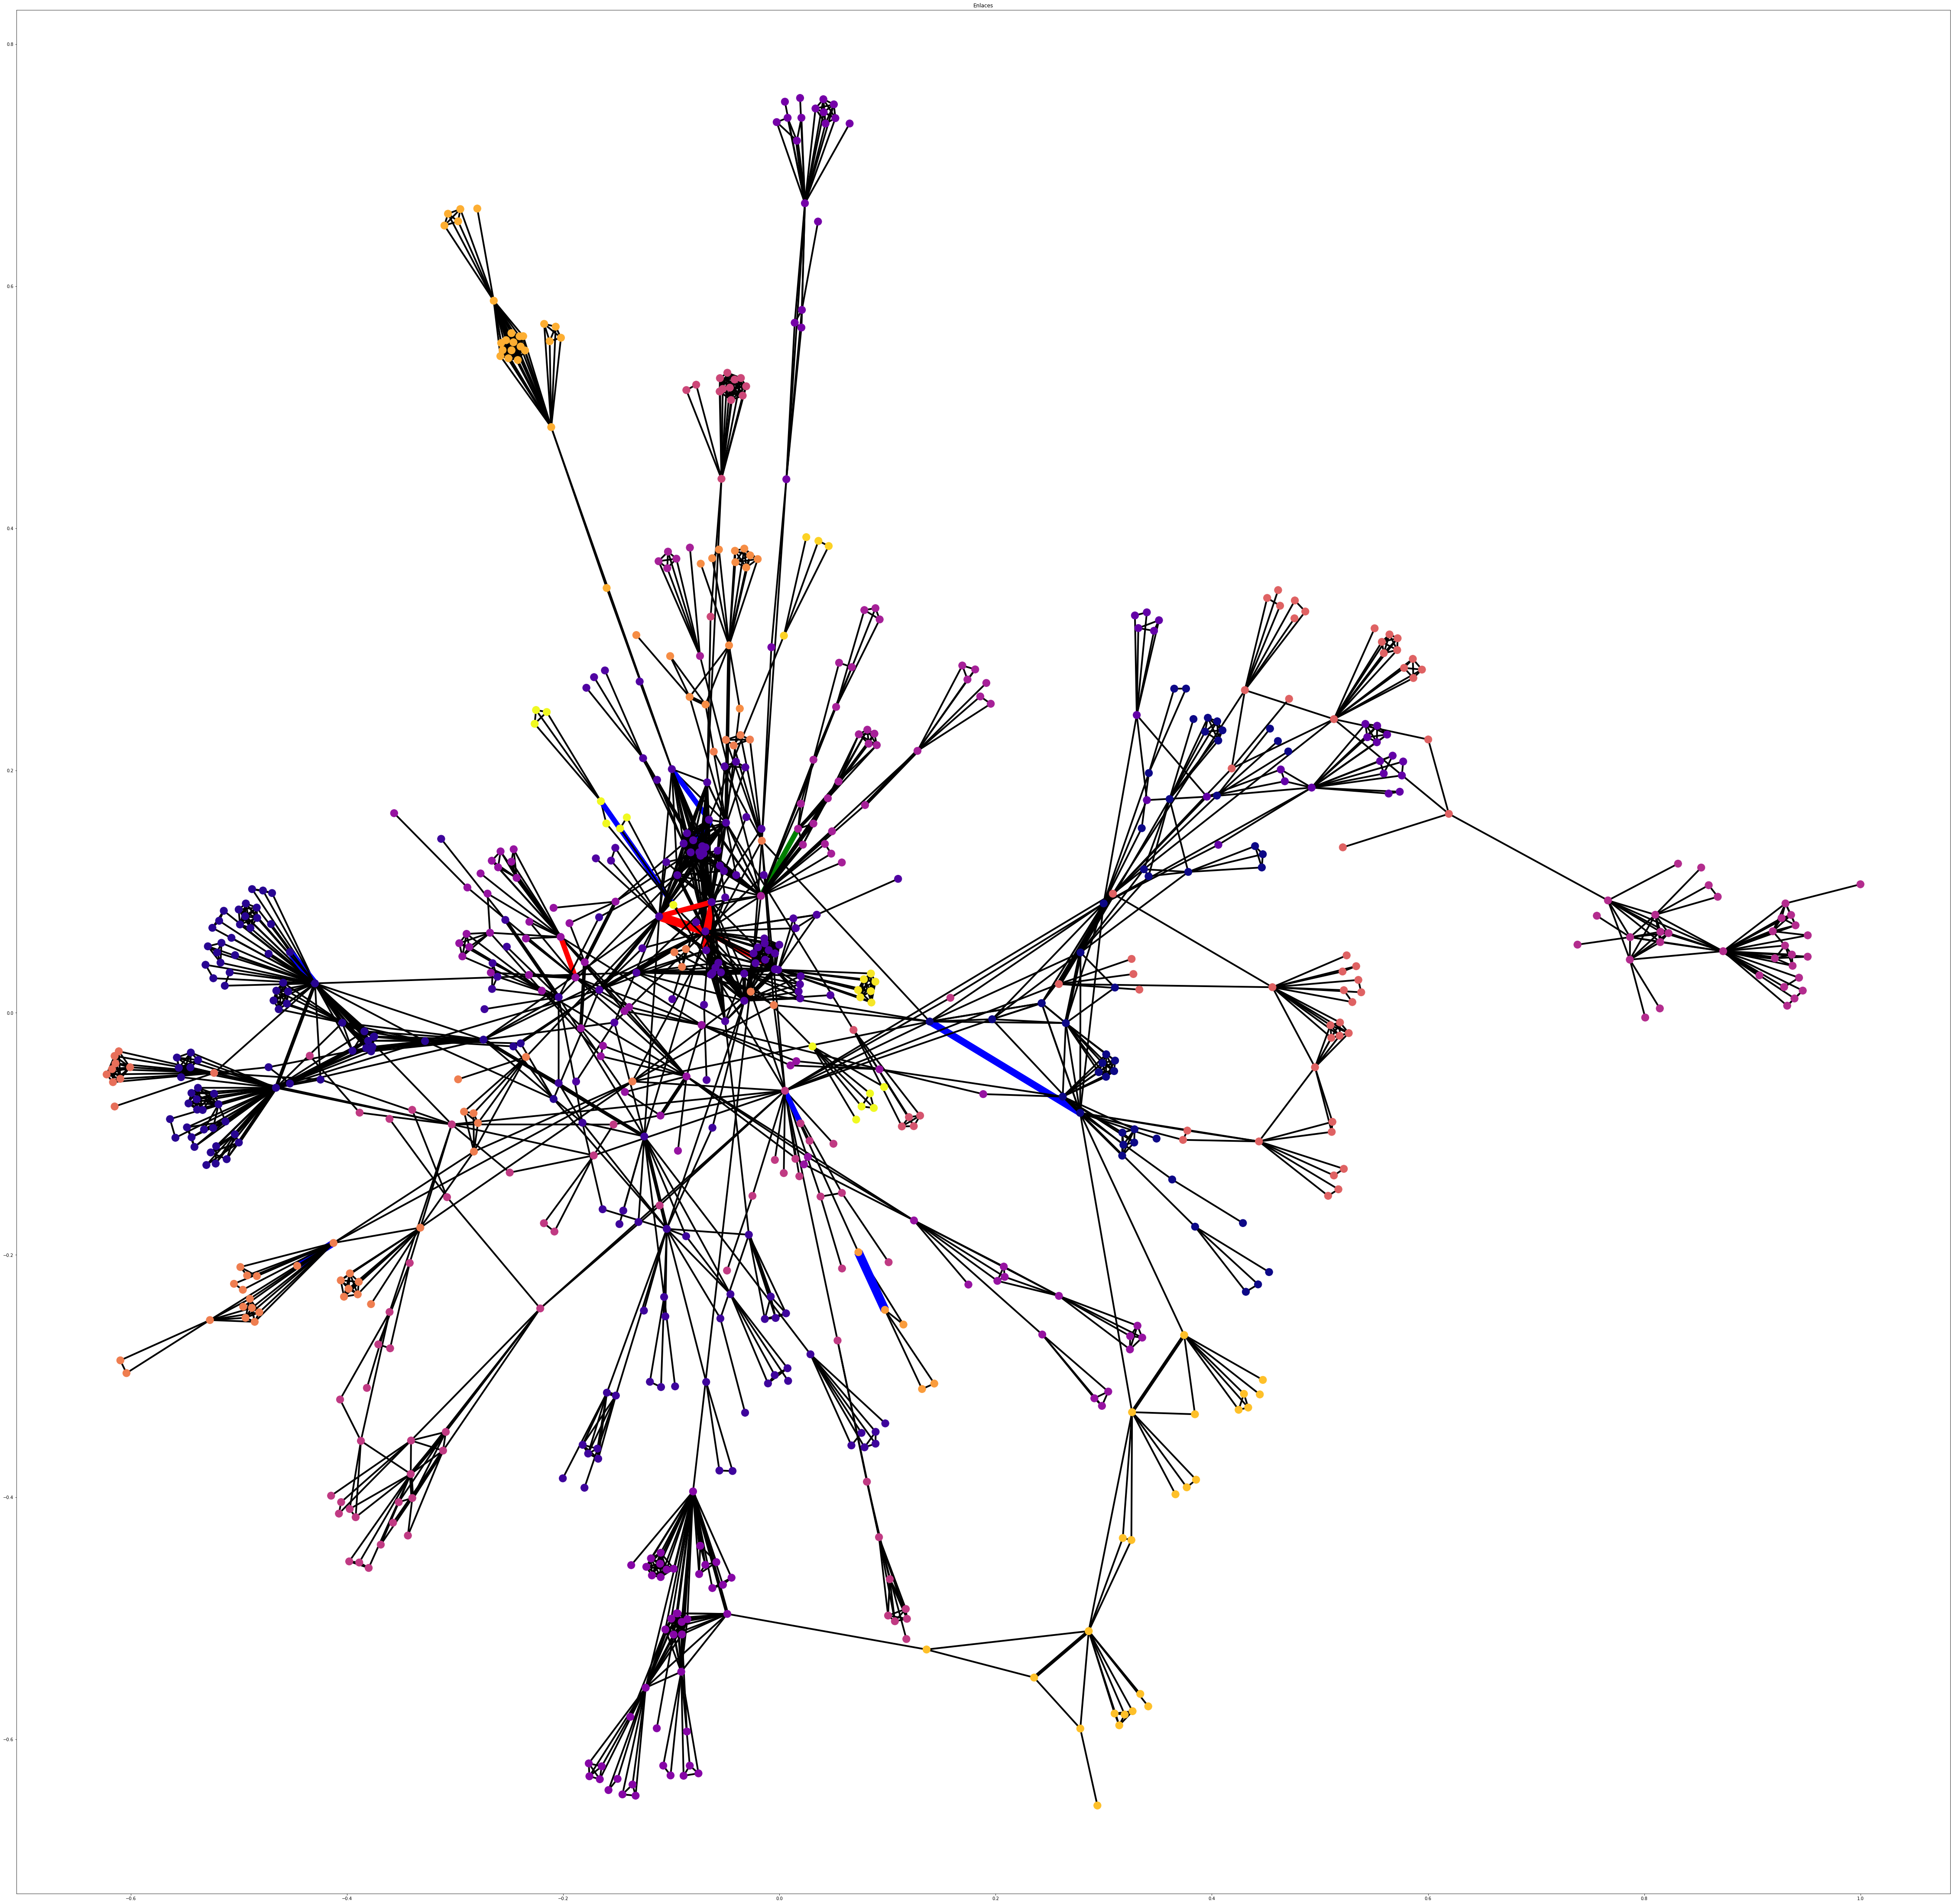

In [59]:
plt.figure(figsize=(80,80))
for name,label in comunidadesPP.items():
    PP.nodes()[name]["color"] = label

nx.draw_networkx(PP, nodelist=list(bet.keys()), 
#                  node_size=[v * 30000 for v in bet.values()],
                 cmap=plt.get_cmap('plasma'),
                 node_color=list(nx.get_node_attributes(PP,'color').values()),
                 edgelist=list(nx.get_edge_attributes(PP,'Color').keys()),
#                  edgelist=listaejes,
                 edge_color=list(nx.get_edge_attributes(PP,'Color').values()),
#                  edge_color=colorejes,
                 width=[t * 20/max(nx.get_edge_attributes(PP,'weight').values()) for t in nx.get_edge_attributes(PP,'weight').values()],
#                  edge_color=['blue' if list(nx.get_edge_attributes(PP,'weight').values())>=5],
#                  width=5,
                 with_labels=False)
plt.title('Enlaces')
# plt.savefig ("Particion_Louvain.png")
plt.show()

## Grafo de sospechosos

In [19]:
grafo_sospechosos_bi = copy.deepcopy(B)
for edge in Bmax.edges():
    if Bmax.edges[edge]['rol']!=['Suspect']:
        grafo_sospechosos_bi.remove_edges_from([edge])

grafo_SS = max(nx.connected_component_subgraphs(nx.algorithms.bipartite.projection.weighted_projected_graph(grafo_sospechosos_bi, personas, ratio=False)), key=len)
grafo_SS = grafo_SS.to_undirected()

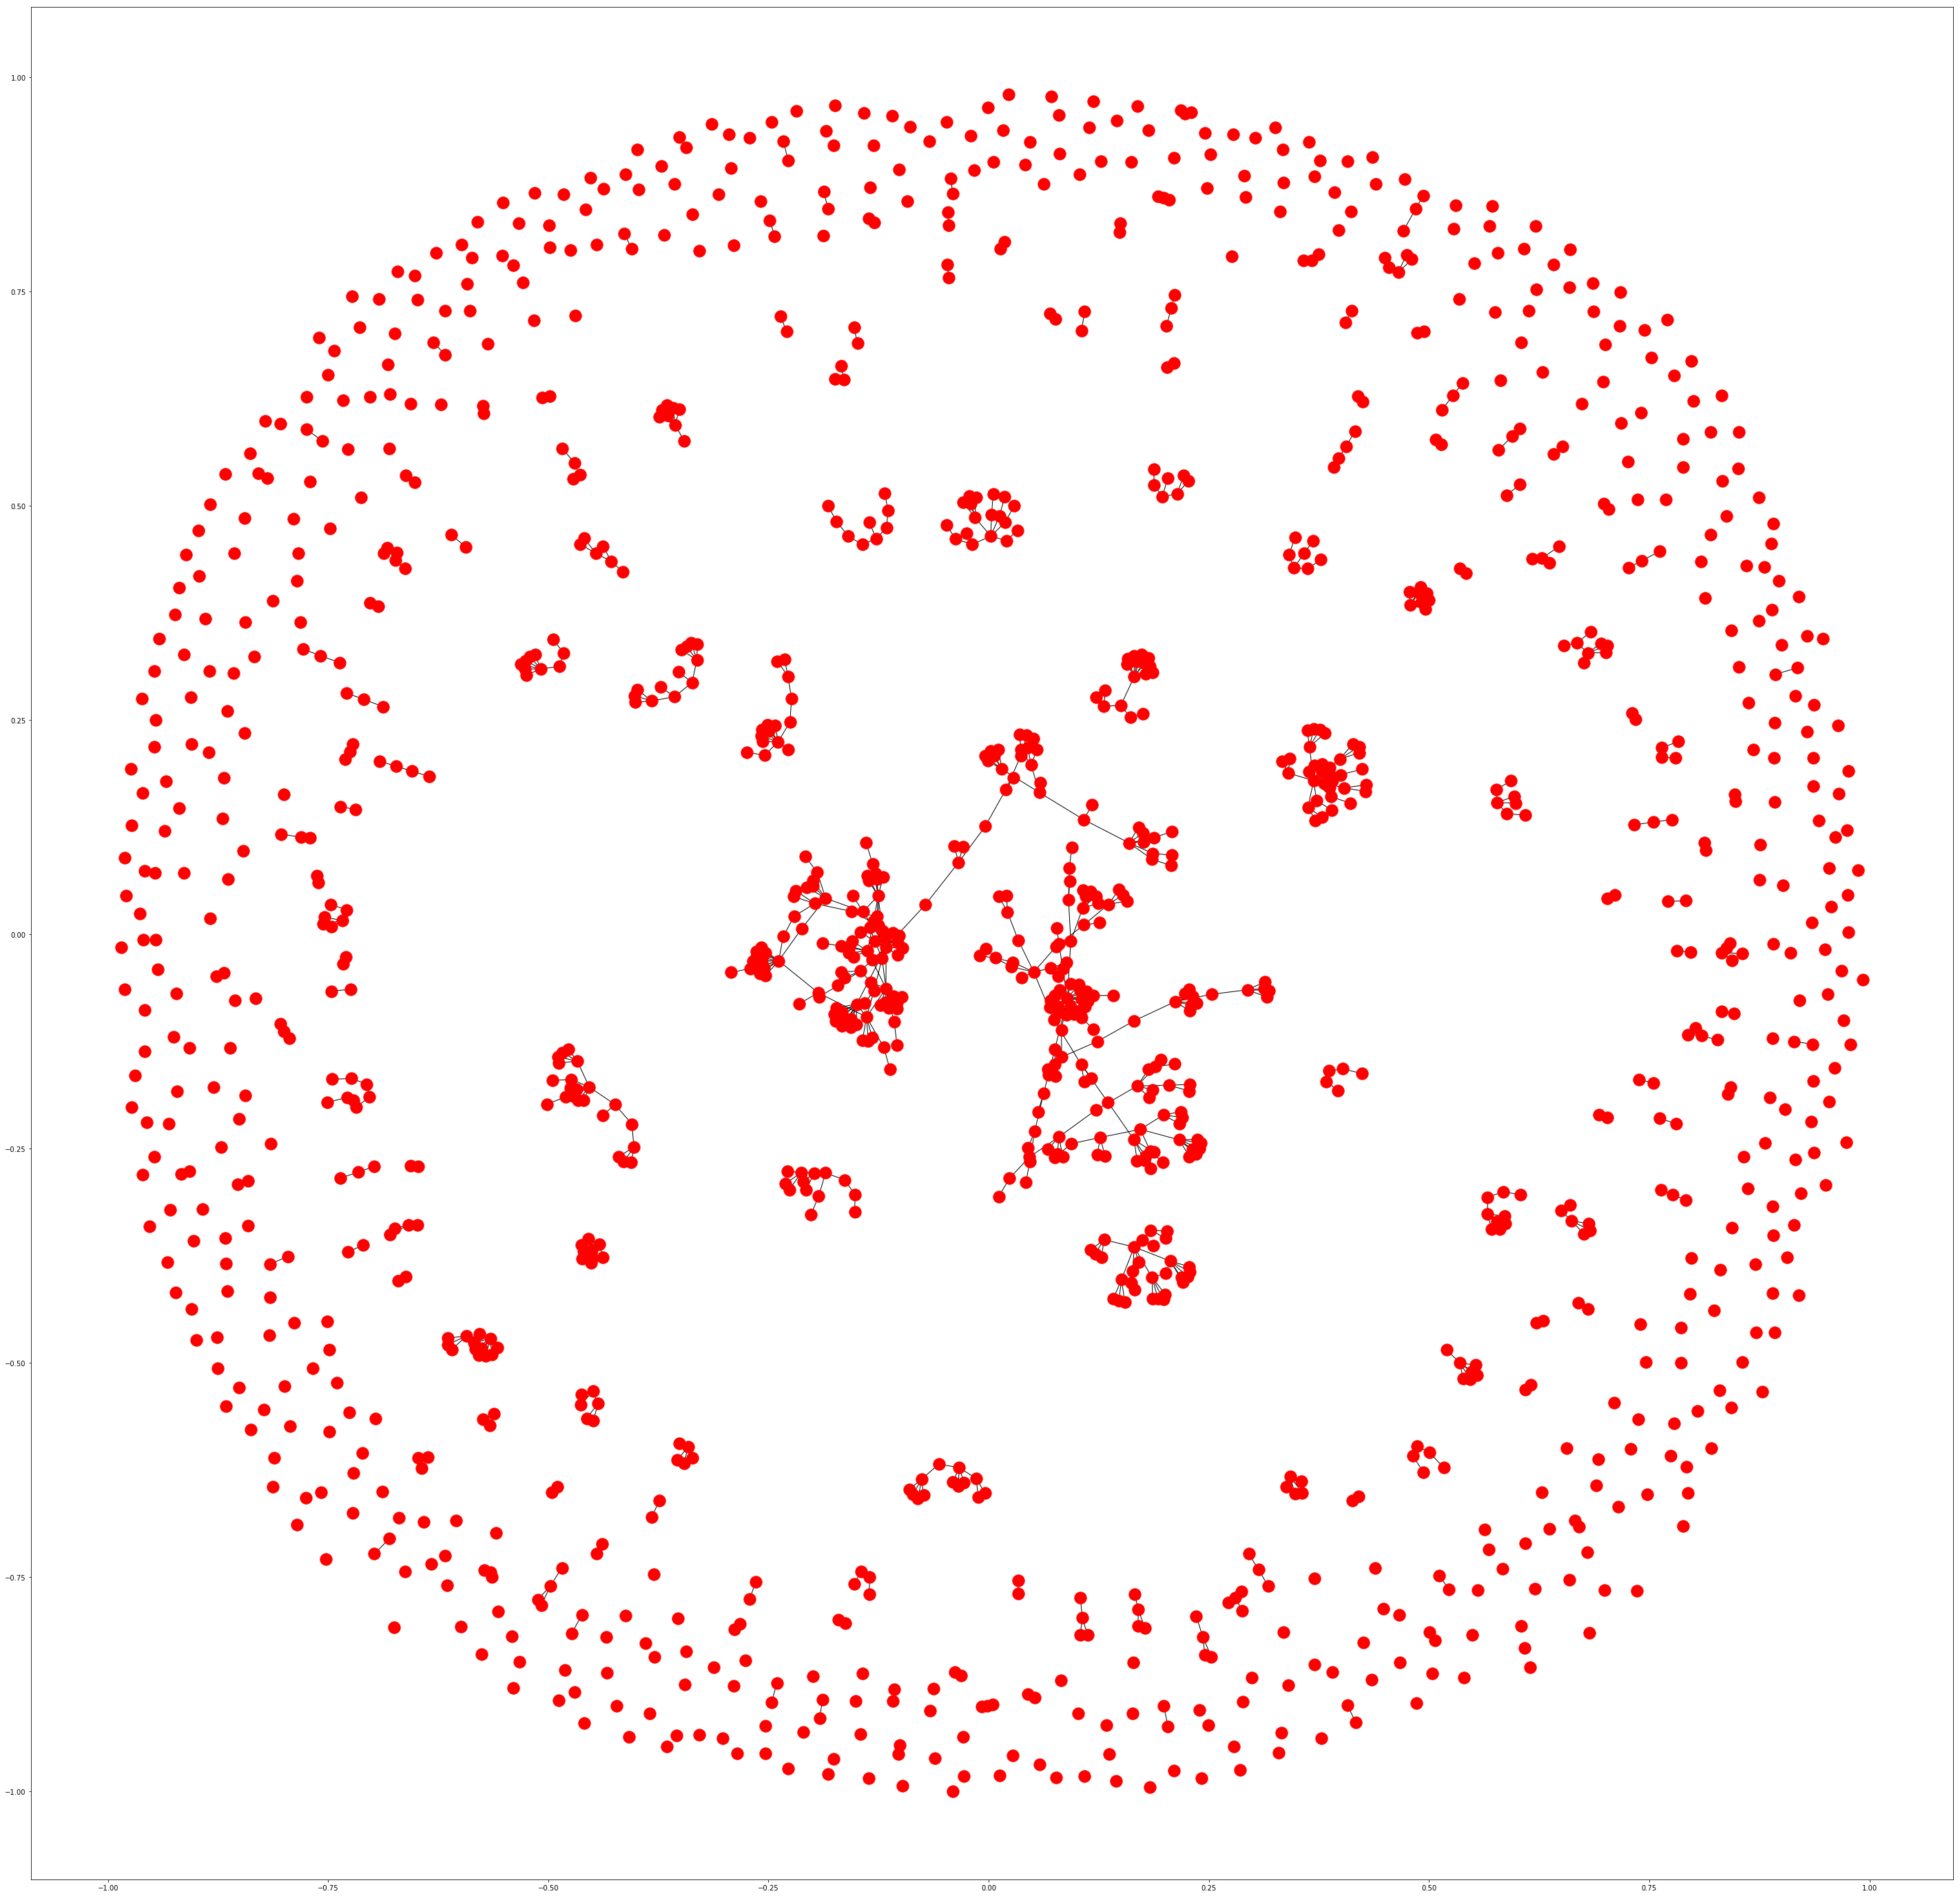

In [22]:
plt.figure(figsize=(50,50))
nx.draw_networkx(grafo_sospechosos_bi, with_labels=False)
plt.show()

# LEER ESTOS PAPERS, TE MUESTRAN COMO PREDECIR LINKS ENTRE PERSONAS. PROBE SACANDO ALGUNOS Y FUINCIONO!! USE JACCARD' COEFFICIENT AND ADAMIC/ADAR

https://arxiv.org/pdf/1507.05739.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4841537/


Jaccard’s coeﬃcient and Adamic/Adar --> https://es.scribd.com/document/112560130/link-prediction-in-social-networks

## Verificamos la estructura k-shell de la red

In [36]:
prueba1 = nx.k_shell(PP,k=3)
prueba2 = nx.k_shell(PP,k=3)
kshell = {}
for i in range(30):
    for node in nx.k_shell(PP,k=i):
        kshell[node]=i
    if len(list(kshell.keys())) == len(list(PP.nodes())):
        break

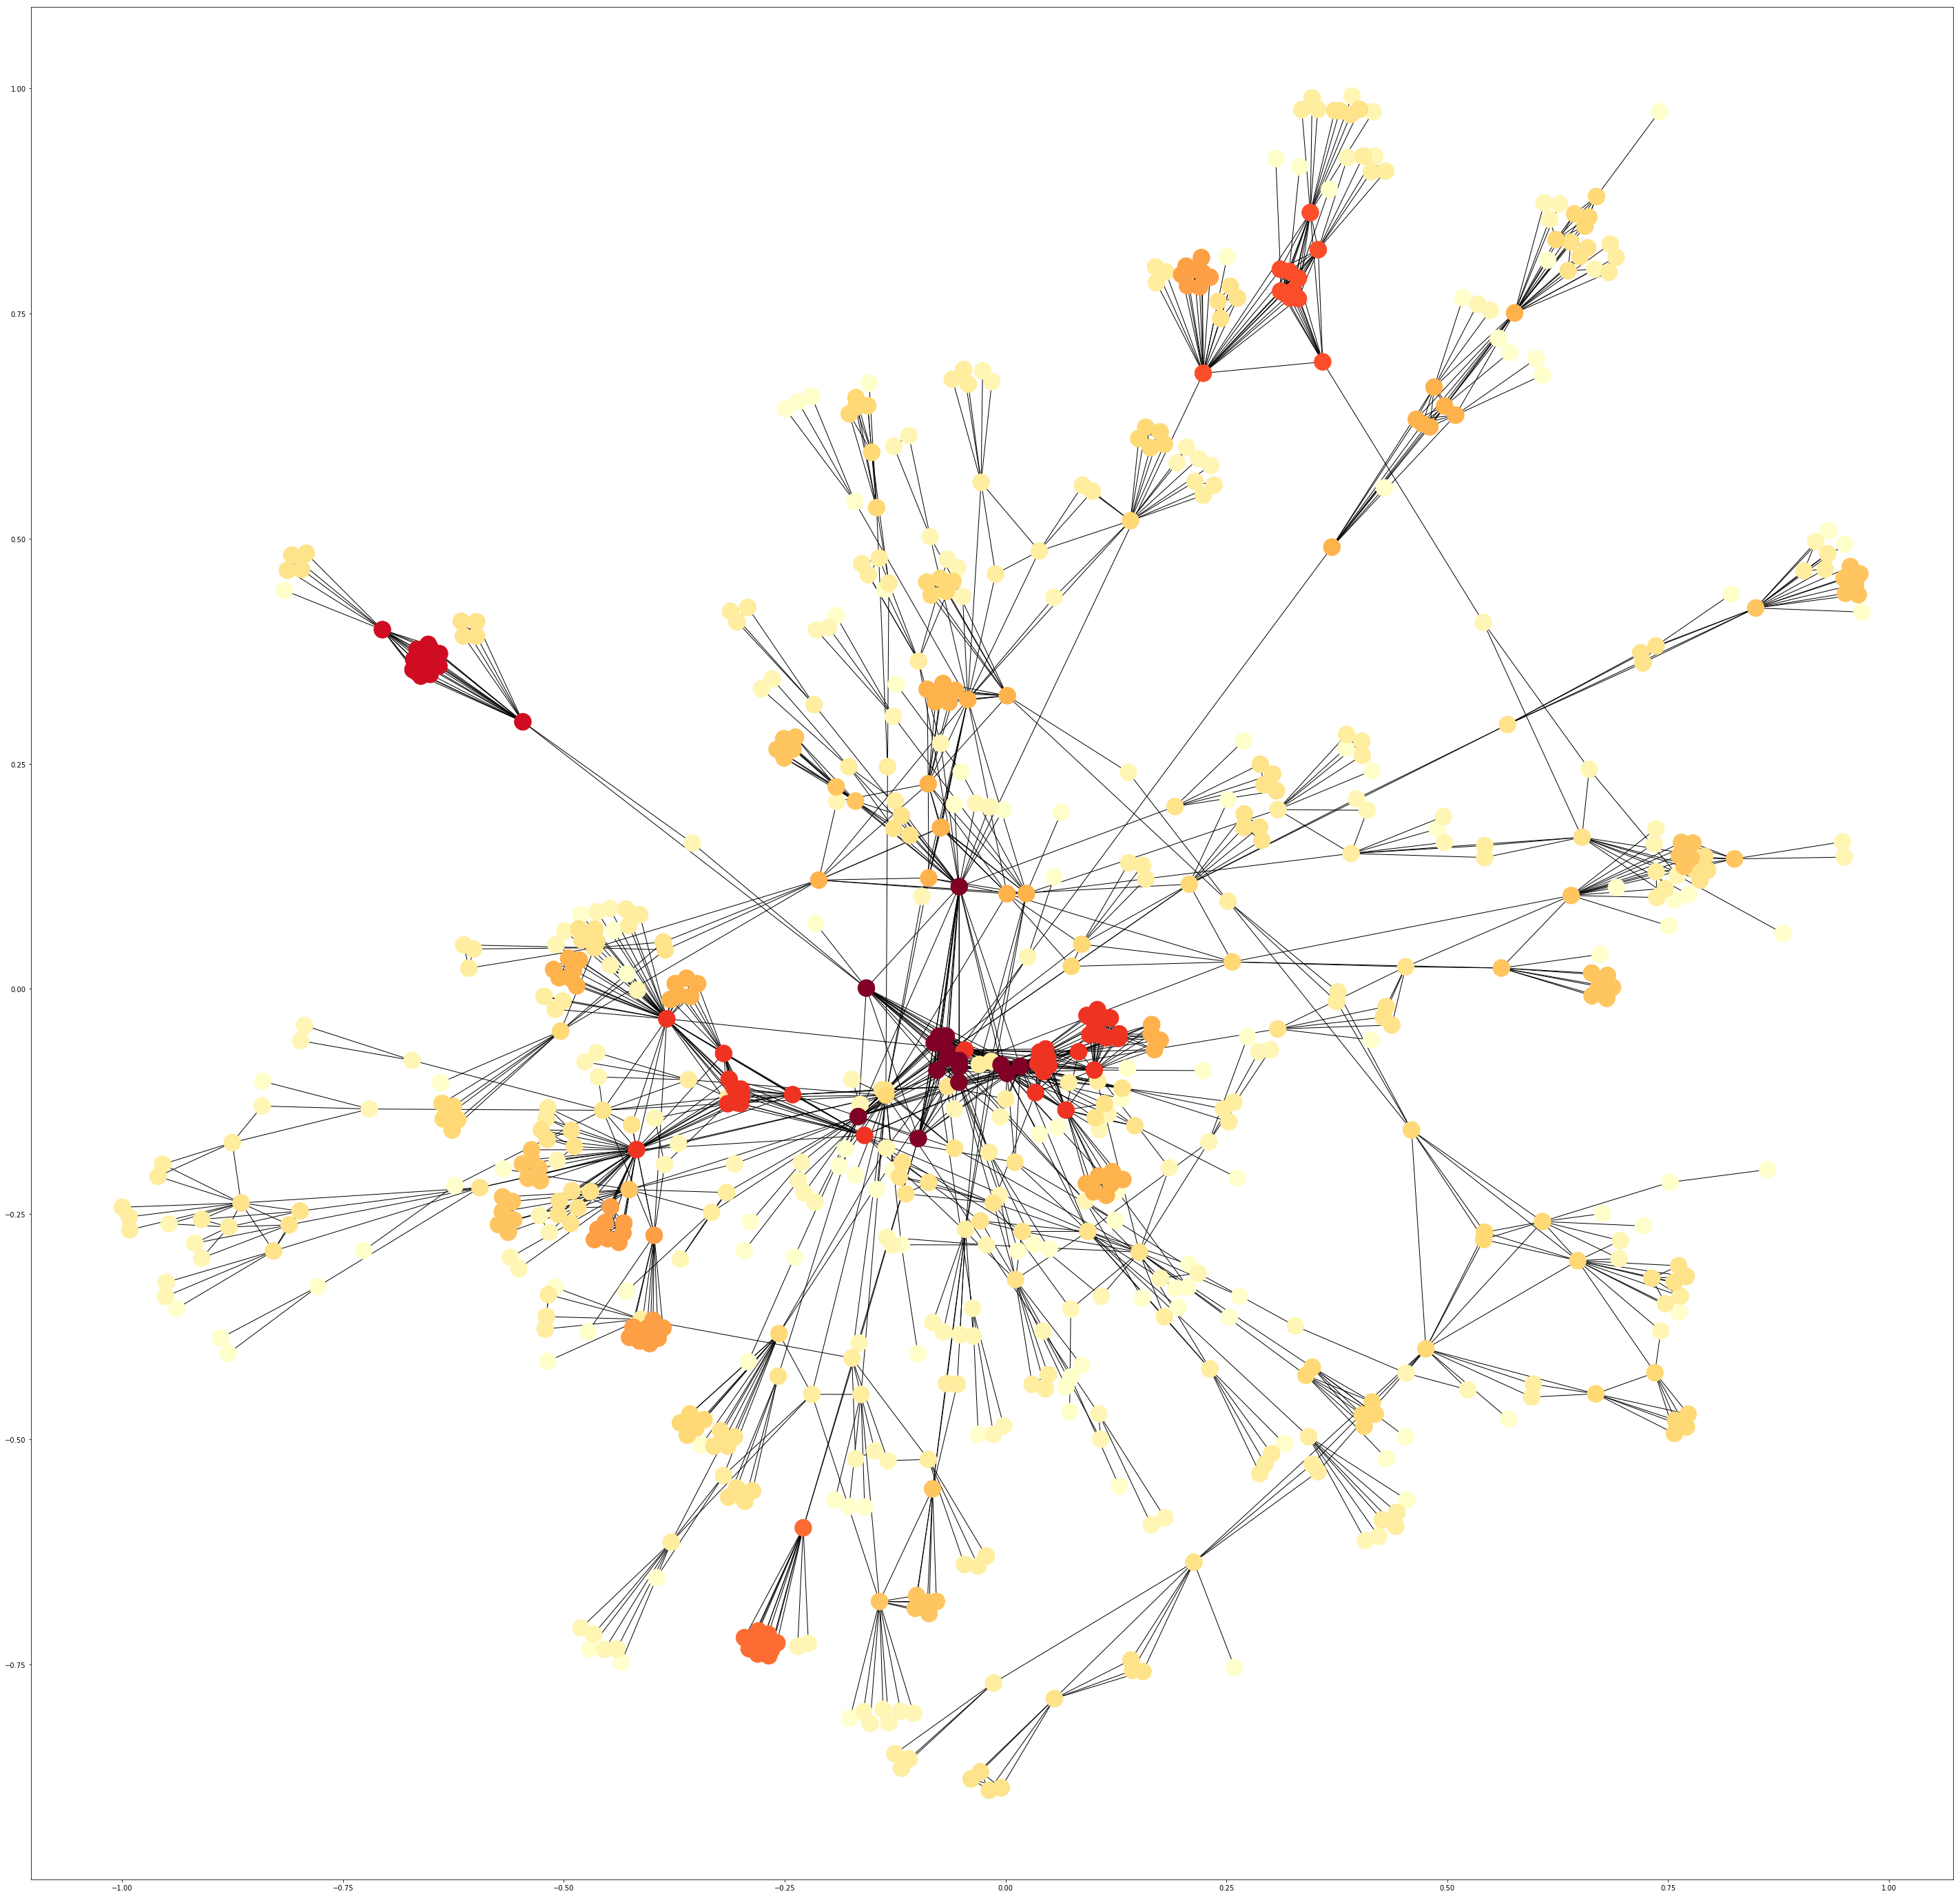

In [61]:
plt.figure(figsize=(50,50))
nx.draw_networkx(PP, nodelist=list(kshell.keys()), node_size=600,
                 node_color=list(kshell.values()),
                 cmap=plt.get_cmap('YlOrRd'), with_labels=False)
plt.show()

In [67]:
pred = nx.adamic_adar_index(PP, ebunch=None)
predictor = []
for u, v, p in pred:
    predictor.append([(u,v),p])

In [70]:
predictor.sort(key=lambda p: p[1], reverse=True)
predictor

[[('815', '336'), 2.3260229922337956],
 [('114', '365'), 1.6072172535335318],
 [('746', '805'), 1.461880214172278],
 [('680', '466'), 1.461880214172278],
 [('680', '245'), 1.461880214172278],
 [('293', '797'), 1.4426950408889634],
 [('269', '155'), 1.4426950408889634],
 [('514', '228'), 1.4426950408889634],
 [('74', '237'), 1.4426950408889634],
 [('301', '815'), 1.4426950408889634],
 [('132', '690'), 1.4426950408889634],
 [('214', '215'), 1.4426950408889634],
 [('695', '691'), 1.4426950408889634],
 [('304', '305'), 1.4328143633706116],
 [('283', '411'), 1.391137573589825],
 [('803', '425'), 1.345902607785922],
 [('647', '425'), 1.345902607785922],
 [('595', '425'), 1.345902607785922],
 [('425', '6'), 1.345902607785922],
 [('74', '151'), 1.3426824550040934],
 [('51', '151'), 1.3426824550040934],
 [('634', '652'), 1.312668831008682],
 [('73', '413'), 1.284196383451722],
 [('97', '413'), 1.284196383451722],
 [('114', '306'), 1.2542611296687707],
 [('114', '15'), 1.2542611296687707],
 [('1

In [75]:
pruebasa=copy.deepcopy(PP)
pruebasa.remove_edges_from([('2','67'),('533','572'),('425','715')])

In [76]:
pred2 = nx.adamic_adar_index(pruebasa, ebunch=None)
predictor2 = []
for u, v, p in pred2:
    predictor2.append([(u,v),p])
predictor2.sort(key=lambda p: p[1], reverse=True)
predictor2

[[('715', '425'), 8.9076562821262],
 [('533', '572'), 7.249145378254274],
 [('815', '336'), 2.3260229922337956],
 [('114', '365'), 1.6085046940248209],
 [('746', '805'), 1.461880214172278],
 [('680', '466'), 1.461880214172278],
 [('680', '245'), 1.461880214172278],
 [('293', '797'), 1.4426950408889634],
 [('2', '67'), 1.4426950408889634],
 [('269', '155'), 1.4426950408889634],
 [('514', '228'), 1.4426950408889634],
 [('74', '237'), 1.4426950408889634],
 [('301', '815'), 1.4426950408889634],
 [('132', '690'), 1.4426950408889634],
 [('214', '215'), 1.4426950408889634],
 [('695', '691'), 1.4426950408889634],
 [('304', '305'), 1.4342268987355544],
 [('283', '411'), 1.391137573589825],
 [('803', '425'), 1.345902607785922],
 [('647', '425'), 1.345902607785922],
 [('595', '425'), 1.345902607785922],
 [('425', '6'), 1.345902607785922],
 [('74', '151'), 1.3426824550040934],
 [('51', '151'), 1.3426824550040934],
 [('634', '652'), 1.312668831008682],
 [('73', '413'), 1.285483823943011],
 [('97', 

### Cosas a ver
* Calcular el coeficiente adamic/adar en caso de que se elimine completamente un crimen de la red bipartita y ver si se puede predecir links entre los sospechosos
* Ver que pasa cuando saco links fuera del nucleo y cuando saco links dentro del nucleo